# 02 Demand Analysis: Aadhaar Service Load Assessment

**Objective**: To identify where Aadhaar service demand is concentrated, which states/districts drive volume, and which demographic groups are the primary users. This analysis informs infrastructure planning and resource allocation.

---

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style for professional, policy-grade visuals
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12

## 1. Data Loading

Loading the prepared district-level aggregations for enrollment, demographic updates, and biometric updates.

In [7]:
# Load datasets
enrollment_df = pd.read_csv('district_monthly_enrollment.csv')
biometric_df = pd.read_csv('district_monthly_biometric.csv')
demographic_df = pd.read_csv('district_monthly_demographic.csv')

# Clean column names just in case (though we expect lowercase)
enrollment_df.columns = enrollment_df.columns.str.lower().str.strip()
biometric_df.columns = biometric_df.columns.str.lower().str.strip()
demographic_df.columns = demographic_df.columns.str.lower().str.strip()

# Display first few rows to verify structure
print("Enrollment Data:")
display(enrollment_df.head())
print("\nBiometric Data:")
display(biometric_df.head())

Enrollment Data:


,state,district,month,age_0_5,age_5_17,age_18_plus,total
0,Delhi,Central Delhi,2025-04,80,41,12,133
1,Delhi,Central Delhi,2025-05,208,105,20,333
2,Delhi,Central Delhi,2025-06,325,156,24,505
3,Delhi,Central Delhi,2025-07,773,328,51,1152
4,Delhi,Central Delhi,2025-09,494,195,36,725



Biometric Data:


,state,district,month,age_0_5,age_5_17,age_18_plus,total
0,Delhi,Central Delhi,2025-03,0,2018,2872,4890
1,Delhi,Central Delhi,2025-04,0,5628,5728,11356
2,Delhi,Central Delhi,2025-05,0,5276,8060,13336
3,Delhi,Central Delhi,2025-06,0,2423,4540,6963
4,Delhi,Central Delhi,2025-07,0,2125,4285,6410


---

## 2. State-Level Service Demand Concentration

### 2.1 Total Enrollment Volume by State
This metric highlights where the initial onboarding demand is highest.

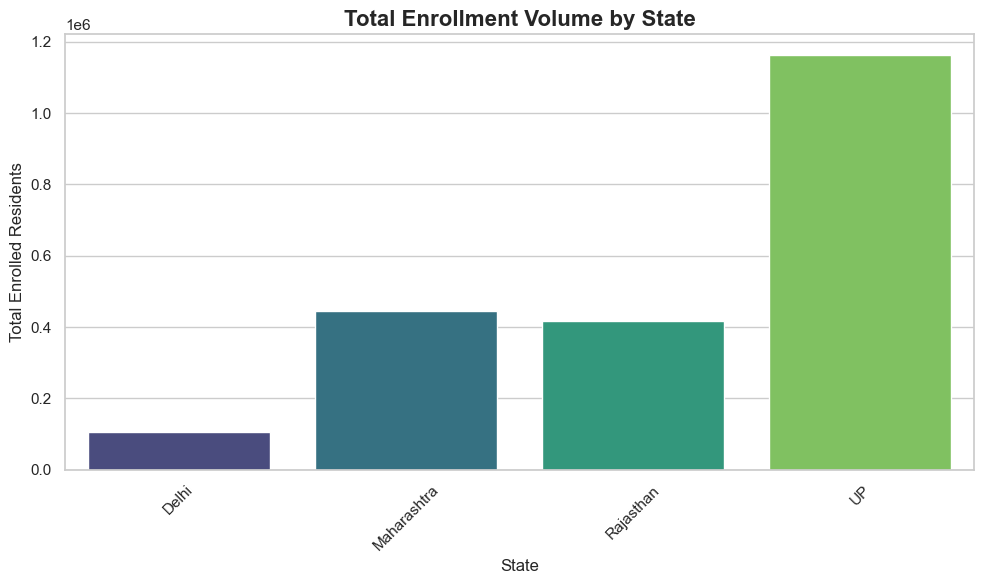

In [8]:
# Aggregating enrollment by state
state_enrollment = enrollment_df.groupby('state')['total'].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=state_enrollment, x='state', y='total', hue='state', palette='viridis', legend=False)
plt.title('Total Enrollment Volume by State', fontweight='bold')
plt.xlabel('State')
plt.ylabel('Total Enrolled Residents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Interpretation**:
The visualization indicates significant variance in enrollment volumes across the selected states. High-volume states require infrastructure scaled for substantially higher concurrent throughput compared to others. This volume directly correlates to the demand for initial setup kits and operator availability.

### 2.2 Total Biometric Updates by State
Biometric updates (fingerprint/iris) are resource-intensive. Monitoring this load is critical for hardware lifecycle planning.

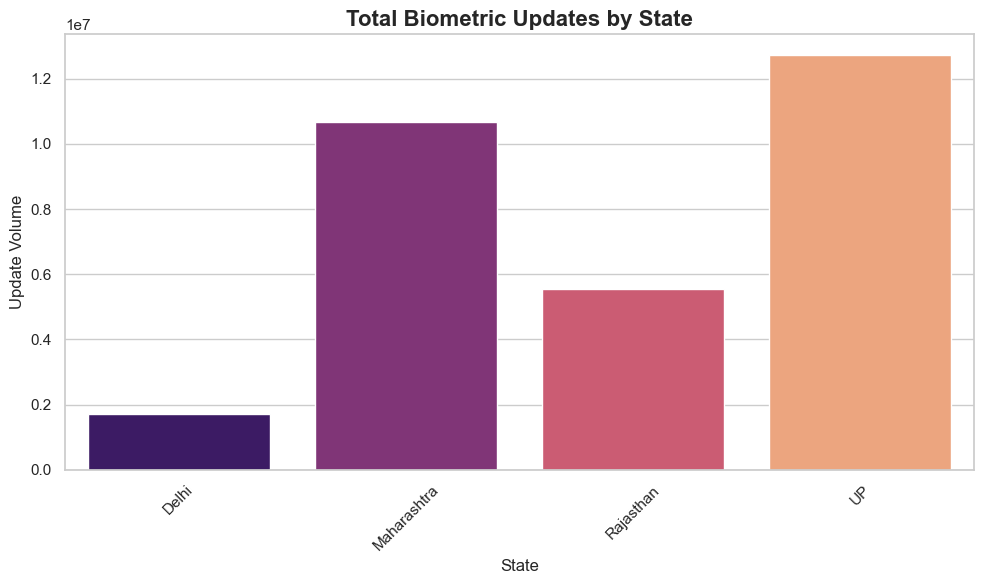

In [9]:
# Aggregating biometric updates by state
state_biometric = biometric_df.groupby('state')['total'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=state_biometric, x='state', y='total', hue='state', palette='magma', legend=False)
plt.title('Total Biometric Updates by State', fontweight='bold')
plt.xlabel('State')
plt.ylabel('Update Volume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Interpretation**:
Biometric update demand patterns often differ from new enrollments. A mature ecosystem sees higher update volumes (MBU/biometric corrections). States with high bars here need persistent service centers rather than temporary camps.

---

## 3. District-Level Hotspots

### 3.1 Top 10 Districts by Biometric Volume
Identifying specific districts that contribute disproportionately to the service load.

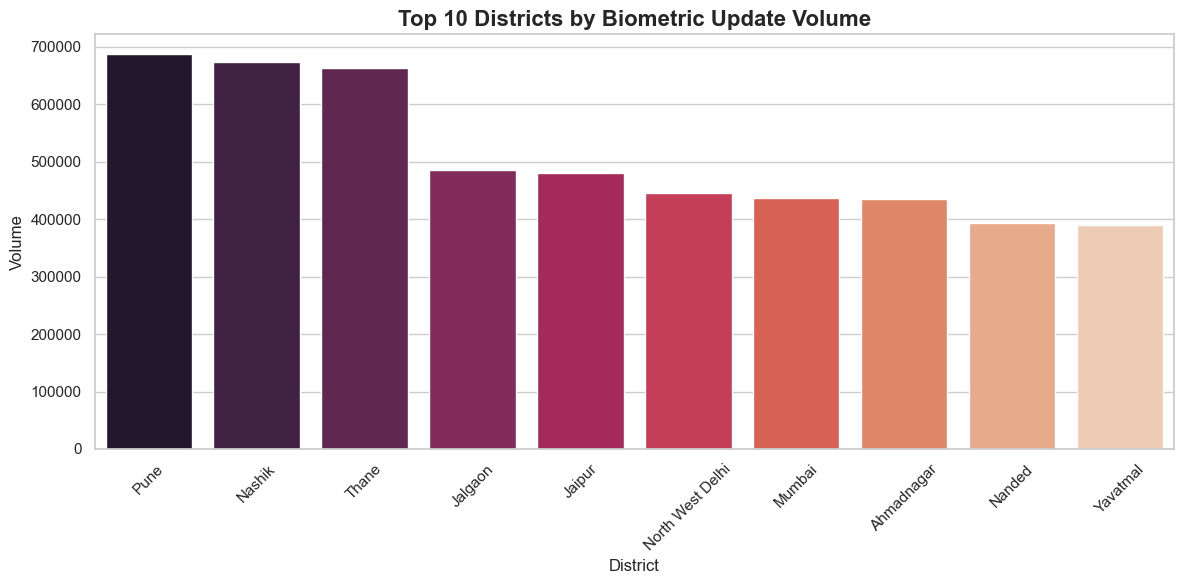

In [10]:
# Aggregating by District to find top contributors
district_biometric = biometric_df.groupby('district')['total'].sum().reset_index()

# Sort and take top 10
top_10_districts = district_biometric.sort_values(by='total', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_districts, x='district', y='total', hue='district', palette='rocket', legend=False)
plt.title('Top 10 Districts by Biometric Update Volume', fontweight='bold')
plt.xlabel('District')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Interpretation**:
These top 10 districts represent the highest pressure points in the network. They likely correspond to major urban centers with high population density. Strategic resource allocation (e.g., placing the largest Aadhaar Seva Kendras) should focus on these specific districts to manage queue lengths and processing times effective.

---

## 4. Demographic Drivers of Demand

### 4.1 Age Group Distribution by State
Understanding which age constituents are utilizing services helps in tailoring service delivery mechanisms.

         state Age Group   Count
0        Delhi   age_0_5       0
1  Maharashtra   age_0_5       0
2    Rajasthan   age_0_5       0
3           UP   age_0_5       0
4        Delhi  age_5_17  688603


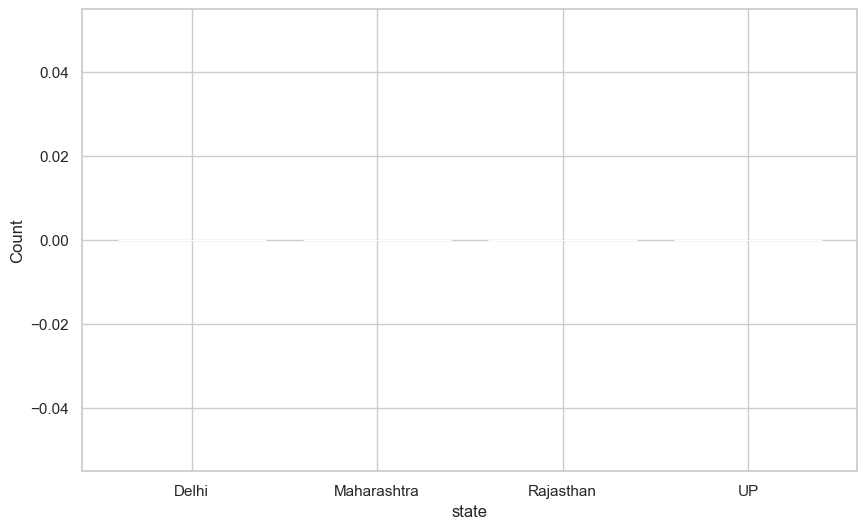

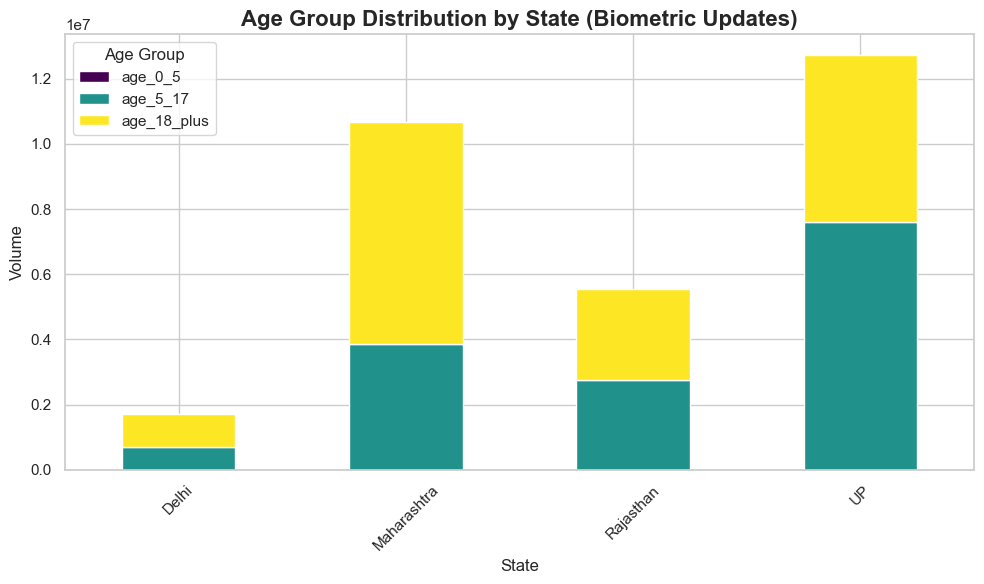

In [11]:
# Analyze Age Groups using Biometric Data
# Columns expected: 'age_0_5', 'age_5_17', 'age_18_plus'
# reshaping for plotting

cols_to_use = ['state', 'age_0_5', 'age_5_17', 'age_18_plus']
age_data = biometric_df[cols_to_use].groupby('state').sum().reset_index()

# Melt for stacked bar plot compatible structure
age_melted = age_data.melt(id_vars='state', var_name='Age Group', value_name='Count')
print(age_melted.head())

plt.figure(figsize=(10, 6))
sns.histplot(data=biometric_df, x='state', weights='age_0_5', color='skyblue', label='0-5', multiple='stack', shrink=0.8)
# Note: histplot with weights is one way, but barplot with 'bottom' parameter is manual.
# An easier way for stacked bars in seaborn is using pandas plot or careful histplot construction.
# Let's use pandas plotting for reliable stacked bars which is cleaner for pre-aggregated data.

age_data.set_index('state').plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Age Group Distribution by State (Biometric Updates)', fontweight='bold')
plt.xlabel('State')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.legend(title='Age Group')
plt.tight_layout()
plt.show()

**Interpretation**:
The stacked bar chart reveals the proportion of demand driven by different age cohorts. Identify if 'age_5_17' is dominant (implying mandatory updates for children) or 'age_18_plus' (implying corrections/adult updates). This informs whether to deploy kits to schools or general banking/post-office centers.